# Naive Bayes classifier

Importing the dataset

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import gensim
import numpy as np


dataset=pd.read_csv("sms_spam.csv")

print(dataset.head())
print ("Shape:", dataset.shape, '\n')

   type                                               text
0   ham  Hope you are having a good week. Just checking in
1   ham                            K..give back my thanks.
2   ham        Am also doing in cbe only. But have to pay.
3  spam  complimentary 4 STAR Ibiza Holiday or £10,000 ...
4  spam  okmail: Dear Dave this is your final notice to...
Shape: (5559, 2) 



Preprocessing function

In [2]:
def transformText(text):
    stops = set(stopwords.words("english"))
    # Convert text to lowercase
    text = text.lower()
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation(text)
    # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
    # Removing all the words with < 3 characters
    text = gensim.parsing.preprocessing.strip_short(text, minsize=3)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Stemming
    return gensim.parsing.preprocessing.stem_text(text)

Preprocessing

In [3]:
transformText(dataset['text'][3])

'complimentari star ibiza holidai cash need urgent collect landlin lose out boxskwpppm'

In [4]:
#applies transformText to all rows of text
dataset['text'] = dataset['text'].map(transformText)
print(dataset['text'].head())

0                                 hope good week check
1                                      give back thank
2                                    also cbe onli pai
3    complimentari star ibiza holidai cash need urg...
4    okmail dear dave final notic collect tenerif h...
Name: text, dtype: object


Creating training and test set

In [5]:
## Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['type'],
                                                    test_size=0.33, random_state=10)

print ("Training Sample Size:", len(X_train), ' ', "Test Sample Size:" ,len(X_test))

Training Sample Size: 3724   Test Sample Size: 1835


Creating a tf-idf model

In [6]:
#Build the counting corpus
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## Get the TF-IDF vector representation of the data
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print ('Dimension of TF-IDF vector :' , X_train_tfidf.shape)

Dimension of TF-IDF vector : (3724, 5056)


Creating the classifier

In [7]:
#Creating the classifier
#MultinomialNB accepts weights instead of Boolean
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0)
# the fit() function of any classifier takes the features from the 
# training set X_train_tfidf and the labels from the training set
# y_train
clf.fit(X_train_tfidf, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


MultinomialNB(alpha=0)

Foldig the test set into the train space

In [8]:
#indexing the test set
X_new_counts = count_vect.transform(X_test)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

Performing the actual prediction

In [9]:
#performing the actual prediction
predicted = clf.predict(X_new_tfidf)

Showing the results

In [10]:
predicted==y_test

2469    True
4107    True
1722    True
3428    True
4747    True
        ... 
1778    True
2330    True
2803    True
3335    True
4704    True
Name: type, Length: 1835, dtype: bool

In [11]:
print(predicted)
print(np.mean(predicted==y_test))

['ham' 'ham' 'ham' ... 'spam' 'ham' 'spam']
0.9771117166212534


## Evaluation metrics

Print prediction probability

In [12]:
predictedProb = clf.predict_proba(X_new_tfidf)
print(predictedProb)

[[1.00000000e+00 8.97003800e-17]
 [1.00000000e+00 5.61486651e-25]
 [1.00000000e+00 3.60030011e-21]
 ...
 [4.26818329e-17 1.00000000e+00]
 [1.00000000e+00 8.42052022e-13]
 [4.46283152e-22 1.00000000e+00]]


Print confusion matrix

In [13]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predicted))

[[1568   15]
 [  27  225]]


Better confusion matrix...

In [14]:
import pandas as pd
print(pd.crosstab(y_test,predicted))

col_0   ham  spam
type             
ham    1568    15
spam     27   225


Accuracy

In [15]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,predicted))

0.9771117166212534


Error rate

In [16]:
print(1-metrics.accuracy_score(y_test,predicted))

0.0228882833787466


Recall

In [17]:
print(metrics.recall_score(y_test, predicted,average=None))

[0.99052432 0.89285714]


Precision

In [18]:
print(metrics.precision_score(y_test,predicted,average=None))

[0.9830721 0.9375   ]


Micro-averaged metrics

In [19]:
print(metrics.recall_score(y_test, predicted,average='micro'))
print(metrics.precision_score(y_test,predicted,average='micro'))

0.9771117166212534
0.9771117166212534


Macro-averaged metrics

In [20]:
print(metrics.recall_score(y_test, predicted,average='macro'))
print(metrics.precision_score(y_test,predicted,average='macro'))

0.941690731883404
0.9602860501567398


Complete report

In [21]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1583
        spam       0.94      0.89      0.91       252

    accuracy                           0.98      1835
   macro avg       0.96      0.94      0.95      1835
weighted avg       0.98      0.98      0.98      1835



F1-score

In [22]:
print(metrics.f1_score(y_test, predicted,average=None))

[0.98678414 0.91463415]


ROC curve

2469    False
4107    False
1722    False
3428     True
4747    False
        ...  
1778    False
2330    False
2803     True
3335    False
4704     True
Name: type, Length: 1835, dtype: bool
[8.97003800e-17 5.61486651e-25 3.60030011e-21 ... 1.00000000e+00
 8.42052022e-13 1.00000000e+00]


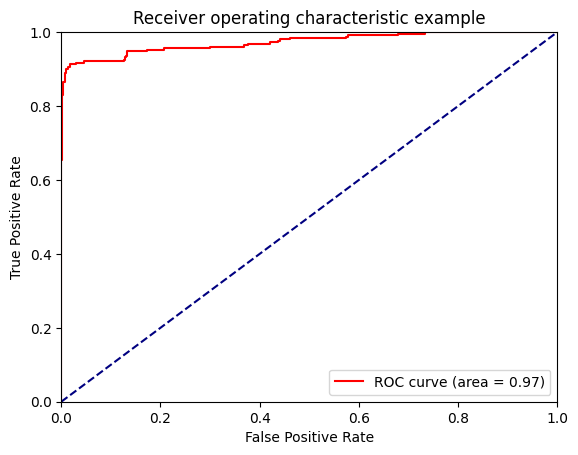

In [23]:
import matplotlib.pyplot as plt
predicted_prob = clf.predict_proba(X_new_tfidf)
print(y_test=='spam')
print(predicted_prob[:,1])
fpr,tpr,thresholds=metrics.roc_curve(y_test=='spam',predicted_prob[:,1])
roc_auc=metrics.auc(fpr, tpr)
plt.plot(
    fpr,
    tpr,
    color="red",
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()


In [32]:
thresholds

array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 9.99999996e-01, 9.99999996e-01,
       9.99999933e-01, 9.99999877e-01, 9.99998668e-01, 9.99997462e-01,
       9.99802316e-01, 9.99780741e-01, 9.92159598e-01, 9.90383248e-01,
       9.86161380e-01, 9.85805465e-01, 9.85077012e-01, 9.80449489e-01,
       9.69840541e-01, 9.59231045e-01, 9.56510782e-01, 9.41571802e-01,
       9.39861797e-01, 8.92723328e-01, 8.02879291e-01, 7.90278926e-01,
       7.83138188e-01, 7.18308052e-01, 7.03148394e-01, 6.71367121e-01,
       6.34298770e-01, 6.06564860e-01, 5.63387189e-01, 5.32879120e-01,
       5.07743590e-01, 4.92399866e-01, 4.87630802e-01, 4.24890684e-01,
       4.19070385e-01, 3.06098278e-01, 2.84800861e-01, 1.43623929e-01,
      

## K-fold validation

Let's check how we have split training and test so far

In [24]:
print(dataset['type'].value_counts())

ham     4812
spam     747
Name: type, dtype: int64


In [25]:
print(y_train.value_counts())

ham     3229
spam     495
Name: type, dtype: int64


In [26]:
print("Spam proportion in the dataset",dataset['type'].value_counts()['spam']/sum(dataset['type'].value_counts()))
print("Spam proportion in the training set",y_train.value_counts()['spam']/sum(y_train.value_counts()))
print("Spam proportion in the test set",y_test.value_counts()['spam']/sum(y_test.value_counts()))


Spam proportion in the dataset 0.13437668645439826
Spam proportion in the training set 0.13292158968850698
Spam proportion in the test set 0.13732970027247957


Let's perform k-fold validation.

First, we apply clean-up and indexing on the whole dataset, not just the training set:

In [27]:
#applies transformText to all rows of text
dataset['text'] = dataset['text'].map(transformText)

#Build the counting corpus
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(dataset['text'])
y=dataset['type']

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_counts)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()


Now, let's perform the cross-validation accumulating the results on each fold:

In [33]:
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=10)

totalPredicted=[]
totalActual=[]
n=0
for train_index, test_index in kf.split(X):
    n+=1
    print("The test index of fold {} is ".format(str(n)),test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    predicted=clf.predict(X_test)
    totalPredicted+=predicted.tolist()
    totalActual+=list(y_test)

print(metrics.classification_report(totalActual,totalPredicted))


The test index of fold 1 is  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 2

Alternatively, we can do it one-shot, by selecting the metrics(s) we are interested in (for example, accuracy):

In [29]:
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)

[0.94964029 0.97482014 0.9676259  0.96582734 0.97841727 0.96942446
 0.97302158 0.96942446 0.97122302 0.94414414]


Other possible metrics are:
- ‘balanced_accuracy’
- ‘roc_auc’
- ‘f1’

In [30]:
from sklearn.model_selection import cross_validate
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}
scores = cross_validate(clf, X, y, scoring=scoring, cv=10, n_jobs=-1)
scores

{'fit_time': array([0.01786494, 0.02084589, 0.02137399, 0.02020001, 0.01851702,
        0.02040911, 0.01880884, 0.02215719, 0.01942921, 0.01765585]),
 'score_time': array([0.01410103, 0.01641107, 0.01449895, 0.0143671 , 0.01767087,
        0.01314592, 0.01519203, 0.01319194, 0.01234579, 0.01156402]),
 'test_acc': array([0.97122302, 0.97661871, 0.96223022, 0.95683453, 0.97661871,
        0.97482014, 0.9676259 , 0.96942446, 0.96402878, 0.95675676]),
 'test_prec_macro': array([0.98393574, 0.98686869, 0.97908367, 0.95264213, 0.97999238,
        0.98585859, 0.98196393, 0.98293173, 0.9649422 , 0.97623762]),
 'test_rec_micro': array([0.89189189, 0.91216216, 0.86      , 0.8568815 , 0.9189605 ,
        0.90666667, 0.88      , 0.88666667, 0.877921  , 0.83783784])}

## Feature importance

In [31]:
neg_class_prob_sorted = clf.feature_log_prob_[0,: ].argsort()[::-1]
pos_class_prob_sorted = clf.feature_log_prob_[1,: ].argsort()[::-1]
print("Ham top 20 features:",np.take(count_vect.get_feature_names_out(), neg_class_prob_sorted[: 20]))
print("Spam top 20 features:",np.take(count_vect.get_feature_names_out(), pos_class_prob_sorted[: 20]))


Ham top 20 features: ['get' 'come' 'call' 'got' 'time' 'like' 'good' 'home' 'know' 'sorri'
 'later' 'lor' 'want' 'dai' 'love' 'need' 'see' 'still' 'tell' 'meet']
Spam top 20 features: ['call' 'free' 'txt' 'mobil' 'prize' 'claim' 'text' 'stop' 'repli'
 'servic' 'www' 'cash' 'new' 'tone' 'contact' 'award' 'urgent' 'min'
 'nokia' 'plea']


In [34]:
neg_class_prob_sorted

array([2043, 1006,  749, ..., 4334, 4332, 1100])

In [35]:
count_vect.get_feature_names_out()

array(['aah', 'aanii', 'aaooooright', ..., 'zouk', 'zyada', '〨ud'],
      dtype=object)

In [37]:
count_vect.get_feature_names_out()[1006]

'come'